## Import libraries

In [1]:
import ee
import geemap
import os
import pandas as pd
import csv

## Create an interactive map

In [2]:
# Map = geemap.Map(center=[40, -100], zoom=4)
Map = geemap.Map()
# Map

## Add Earth Engine Python script

In [3]:
#Convert 'nilai' property from string to number.
def func_vjt(feature):
    num = ee.Number.parse(feature.get('nilai'))
    return feature.set('nilai', num)

# Add Earth Engine dataset
# image = ee.Image("USGS/SRTMGL1_003")
polygons = ee.FeatureCollection('projects/elisabethg/assets/box_karawang');

# Sample in 2020 , metode ekstrapolasi. dr point menjadi area
# kalau mau data trainingnya , bisa januari, april, dan agustus yang menggambarkan karakter yang sama
sample1 = ee.FeatureCollection('projects/elisabethg/assets/2020_04').map(func_vjt)

In [4]:
# Get time for prediction
start_date = ee.Date('2020-04-01')
finish_date = ee.Date('2020-04-30')
orbit = 'ASCENDING'

# januari: 1-31
# feb: 1-29
# maret: 1-31
# april: 1-30
# mei: 1-31
# juni: 1-30
# juli: 1-31
# agustus: 1-31
# september: 1-30
# oktober: 1-31
# november: 1-30
# des: 1-31

In [5]:
def func_mgd(image):
    return image.clip(polygons)

# Get the VV collection.
collectionS1 = ee.ImageCollection('COPERNICUS/S1_GRD').map(func_mgd) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .filterDate(start_date, finish_date) \
    .filterBounds(polygons)

In [6]:
collectionVV = collectionS1.select('VV')
collectionVH = collectionS1.select('VH')


VV = ee.Image(collectionVV.median())
VH = ee.Image(collectionVH.median())
VVVH = VV.divide(VH)

bandsall = ['0_VH', '1_VV', '2_VV']
bandsvh = ['0_VH']
bandsvv = ['1_VV']
bandsvvvh = ['2_VV']

mosaic = collectionVV.mosaic()

fincol = ee.ImageCollection([VH, VV, VVVH])
finLayer = fincol.toBands()

In [7]:
# Training seluruh bulan
label = 'nilai'
trainingall = finLayer.select(bandsall).sampleRegions(collection= sample1, properties= [label], scale = 12);

In [8]:
# trainedsv = ee.Classifier.libsvm().train(trainingall, label, bandsall)
# classifiedsv = finLayer.select(bandsall).classify(trainedsv)

# trainedmd = ee.Classifier.minimumDistance().train(trainingall, label, bandsall)
# classifiedmd = finLayer.select(bandsall).classify(trainedmd)

# trainednb = ee.Classifier.smileNaiveBayes().train(trainingall, label, bandsall)
# classifiednb = finLayer.select(bandsall).classify(trainednb)

# trainedall = ee.Classifier.smileCart().train(trainingall, label, bandsall)
# classifiedall = finLayer.select(bandsall).classify(trainedall)

# trainedtb = ee.Classifier.smileGradientTreeBoost(10).train(trainingall, label, bandsall)
# classifiedtb = finLayer.select(bandsall).classify(trainedtb)

trainedrf = ee.Classifier.smileRandomForest(10).train(trainingall, label, bandsall)
classifiedrf = finLayer.select(bandsall).classify(trainedrf)


In [9]:
Map.centerObject(polygons, 11)
Map.addLayer(sample1, {}, 'Sampel', True)

In [10]:
# Map.addLayer(classifiedsv, {'min': 0, 'max': 3, 'palette': ['red', 'green', 'blue', 'cyan', 'yellow', 'white']}, 'Class SVM')
# Map.addLayer(classifiedmd, {'min': 0, 'max': 3, 'palette': ['red', 'green', 'blue', 'cyan', 'yellow', 'white']}, 'Class Min Distance')
# Map.addLayer(classifiednb, {'min': 0, 'max': 3, 'palette': ['red', 'green', 'blue', 'cyan', 'yellow', 'white']}, 'Class Naive Bayes')
# Declare warna-warna di map. index array sesuai nomor zone
palette = ['blue', 'cyan', 'green', 'magenta', 'yellow', 'white', 'grey', 'red']

#Deklarasi Map
# Map.addLayer(classifiedall, {'min': 0, 'max': 8, 'palette': palette}, 'Class CART')
# Map.addLayer(classifiedtb, {'min': 0, 'max': 8, 'palette': palette}, 'Class Grad Tree Boost')
Map.addLayer(classifiedrf, {'min': 0, 'max': 8, 'palette': palette}, 'Class Random Forest')

In [11]:
# zonessv = classifiedsv.gt(0).add(classifiedsv.gt(1)) \
# .add(classifiedsv.gt(2)) \
# .add(classifiedsv.gt(3)) \
# .add(classifiedsv.gt(4)) \
# .add(classifiedsv.gt(5))

# zonesmd = classifiedmd.gt(0).add(classifiedmd.gt(1)) \
# .add(classifiedmd.gt(2)) \
# .add(classifiedmd.gt(3)) \
# .add(classifiedmd.gt(4)) \
# .add(classifiedmd.gt(5))

# zonesnb = classifiednb.gt(0).add(classifiednb.gt(1)) \
# .add(classifiednb.gt(2)) \
# .add(classifiednb.gt(3)) \
# .add(classifiednb.gt(4)) \
# .add(classifiednb.gt(5))

# zonesall = classifiedall.gt(0).add(classifiedall.gt(1)) \
# .add(classifiedall.gt(2)) \
# .add(classifiedall.gt(3)) \
# .add(classifiedall.gt(4)) \
# .add(classifiedall.gt(5)) \
# .add(classifiedall.gt(6)) \
# .add(classifiedall.gt(7))

# zonestb = classifiedtb.gt(0).add(classifiedtb.gt(1)) \
# .add(classifiedtb.gt(2)) \
# .add(classifiedtb.gt(3)) \
# .add(classifiedtb.gt(4)) \
# .add(classifiedtb.gt(5)) \
# .add(classifiedtb.gt(6)) \
# .add(classifiedtb.gt(7))


zonesrf = classifiedrf.gt(0).add(classifiedrf.gt(1)) \
.add(classifiedrf.gt(2)) \
.add(classifiedrf.gt(3)) \
.add(classifiedrf.gt(4)) \
.add(classifiedrf.gt(5)) \
.add(classifiedrf.gt(6)) \
.add(classifiedrf.gt(7))

# vectorssv = zonessv.addBands(classifiedsv).reduceToVectors(reducer= ee.Reducer.mean(), geometry= polygons, crs=classifiedsv.projection(), scale= 100,geometryType= 'polygon', eightConnected= False, labelProperty= 'zone')
# vectorsmd = zonesmd.addBands(classifiedmd).reduceToVectors(reducer= ee.Reducer.mean(), geometry= polygons, crs=classifiedmd.projection(), scale= 100,geometryType= 'polygon', eightConnected= False, labelProperty= 'zone')
# vectorsnb = zonessv.addBands(classifiednb).reduceToVectors(reducer= ee.Reducer.mean(), geometry= polygons, crs=classifiednb.projection(), scale= 100,geometryType= 'polygon', eightConnected= False, labelProperty= 'zone')

# vectorsall = zonesall.addBands(classifiedall).reduceToVectors(geometry= polygons, crs=classifiedall.projection(), scale= 100,geometryType= 'polygon', eightConnected= False, labelProperty= 'zone', reducer= ee.Reducer.mean())
# vectorstb = zonestb.addBands(classifiedtb).reduceToVectors(geometry= polygons, crs=classifiedtb.projection(), scale= 100,geometryType= 'polygon', eightConnected= False, labelProperty= 'zone', reducer= ee.Reducer.mean())
# vectorsrf = zonesrf.addBands(classifiedrf).reduceToVectors(geometry= polygons, crs=classifiedrf.projection(), scale= 100,geometryType= 'polygon', eightConnected= False, labelProperty= 'zone', reducer= ee.Reducer.mean())


## Download

In [12]:
# # Mau liat map yg udh dicrop
polygons1 = ee.FeatureCollection('projects/elisabethg/assets/kab_karawang')
new1 = classifiedrf.clip(polygons1)
# # Crop itu yg label 1-4 aja
# # standing crop: v1,v2, dan g
# Map.addLayer(new1, {'min': 1, 'max': 4, 'palette': palette}, 'CART - Crop')

In [13]:
# new2 = vectorsall.filter(ee.Filter.bounds(polygons1))
# # Map.addLayer(new2, {'min': 0, 'max': 3, 'palette': ['red', 'green', 'blue', 'cyan', 'yellow', 'white']}, 'baru')
# url = new1.getDownloadURL('csv')
print(new1)

ee.Image({
  "functionInvocationValue": {
    "functionName": "Image.clip",
    "arguments": {
      "geometry": {
        "functionInvocationValue": {
          "functionName": "Collection.loadTable",
          "arguments": {
            "tableId": {
              "constantValue": "projects/elisabethg/assets/kab_karawang"
            }
          }
        }
      },
      "input": {
        "functionInvocationValue": {
          "functionName": "Image.classify",
          "arguments": {
            "classifier": {
              "functionInvocationValue": {
                "functionName": "Classifier.train",
                "arguments": {
                  "classProperty": {
                    "constantValue": "nilai"
                  },
                  "classifier": {
                    "functionInvocationValue": {
                      "functionName": "Classifier.smileRandomForest",
                      "arguments": {
                        "numberOfTrees": {
                 

In [14]:
# new2 = ee.Image.pixelLonLat() # buat 2 band baru yang berisi informasi X dan Y
# new3 = new1.addBands(new2) # tambahkan kedua band tersebut ke hasil pemodelan
# Map.addLayer(new2, {}, 'Pixels') # tampilkan di map
# vectors = new3.sample(region=polygons, scale=100, geometries=True) # resampling image dengan skala 10000. Scale=10000 mencerminkan resampling dilakukan seti1p 10.000 meter = 10 km. Ini hanya untuk memberikan gambaran saja. Tuk kondisi sebenarnya resampling scale=10 atau scale=100.
# # print(vectors)
# out_shp = 'Downloads/randomforest-12.csv' # definisikan letak dan nama file keluaran
# geemap.ee_to_csv(vectors, out_shp) #export menjadi shape file (atau CSV, terserah). Pada contoh 

## Hitung Akurasi

In [15]:
# Sample Validasi
sampleCoba = ee.FeatureCollection('projects/elisabethg/assets/2020_04').map(func_vjt)

# Dataset Validasi
validation = finLayer.select(bandsall).sampleRegions(collection= sampleCoba, properties= [label], scale = 12);

# Training machine learning
# trainedall1 = ee.Classifier.smileCart().train(trainingall, label, bandsall)
trainedrf1 = ee.Classifier.smileRandomForest(10).train(trainingall, label, bandsall)
#trainedtb1 = ee.Classifier.smileGradientTreeBoost(10).train(trainingall, label, bandsall)

validated = validation.classify(trainedrf1)

# Referensi: https://book.geemap.org/chapters/06_data_analysis.html#accuracy-assessment
test_accuracy = validated.errorMatrix('nilai','classification')

# # test_accuracy.getInfo()
test_accuracy.accuracy().getInfo()

0.9260571175558999

In [16]:
test_accuracy.getInfo()

[[1936, 8, 8, 10, 6, 0, 6, 5],
 [32, 375, 6, 3, 2, 0, 0, 0],
 [25, 12, 283, 9, 2, 0, 1, 0],
 [34, 2, 6, 406, 2, 0, 2, 1],
 [6, 6, 1, 13, 199, 0, 0, 4],
 [0, 0, 0, 0, 0, 12, 0, 2],
 [47, 2, 6, 13, 4, 0, 412, 20],
 [6, 1, 1, 3, 3, 0, 14, 560]]

In [17]:
test_accuracy.kappa().getInfo()

0.9005989581548917

In [18]:
test_accuracy.producersAccuracy().getInfo()

[[0.9782718544719555],
 [0.8971291866028708],
 [0.8524096385542169],
 [0.8962472406181016],
 [0.868995633187773],
 [0.8571428571428571],
 [0.8174603174603174],
 [0.9523809523809523]]

In [19]:
test_accuracy.consumersAccuracy().getInfo()

[[0.9280920421860019,
  0.9236453201970444,
  0.909967845659164,
  0.888402625820569,
  0.9128440366972477,
  1,
  0.9471264367816092,
  0.9459459459459459]]

In [20]:
import csv
import os

out_dir = os.getcwd()
# training_csv = os.path.join(out_dir, 'train_accuracy.csv')
testing_csv = os.path.join(out_dir, 'test_accuracy.csv')

with open(testing_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(test_accuracy.getInfo())

## Display Map

In [21]:
Map

Map(center=[-6.2602313619008285, 107.37305787739075], controls=(WidgetControl(options=['position', 'transparen…

# Hitung Luas

In [22]:
import pandas as pd
import numpy as np
import csv

#Fungsi cek keberadaan zona
def isFoundZone(dfcount, zone):
    for ind in dfcount.index:
        if dfcount['Zone'][ind] == zone:
            return True
    return False

## Januari 2020

In [23]:
#Baca file CSV
csvfile01 = pd.read_csv('randomforest-01.csv')
csvfile01.head()

#Membuat dataframe untuk hasil akhir
df01 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df01['Zone'] = [0,1,2,3,4,5,6,7]
df01['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen dan Persiapan Lahan', 'Sawah tidak ditanami Padi', 'Lain-lain','Permukiman dan Jalan']
df01['Count'] = [0,0,0,0,0,0,0,0]
df01['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile01 = pd.DataFrame(csvfile01)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount01 = dfcsvfile01.classification.value_counts()
dfcount01 = dfcount01.reset_index()
dfcount01.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df01.index:
    if isFoundZone(dfcount01, ind) == True:
        df01.loc[(df01.Zone == ind), "Count"] = dfcount01.loc[dfcount01['Zone'] == ind, 'Count'].item()
    else:
         df01.loc[(df01.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan satuan hektar
df01['Widearea']= df01['Count']
df01

#Melihat dataframe hasil akhir
df01

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,43463,43463
1,1,Vegetasi Awal,5991,5991
2,2,Vegetasi Akhir,3037,3037
3,3,Generatif,660,660
4,4,Panen dan Persiapan Lahan,83060,83060
5,5,Sawah tidak ditanami Padi,355,355
6,6,Lain-lain,15698,15698
7,7,Permukiman dan Jalan,43419,43419


## Februari 2020

In [24]:
#Baca file CSV
csvfile02 = pd.read_csv('randomforest-02.csv')
csvfile02.head()

#Membuat dataframe untuk hasil akhir
df02 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df02['Zone'] = [0,1,2,3,4,5,6,7]
df02['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen dan Persiapan Lahan', 'Sawah tidak ditanami Padi', 'Lain-lain','Permukiman dan Jalan']
df02['Count'] = [0,0,0,0,0,0,0,0]
df02['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile02 = pd.DataFrame(csvfile02)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount02 = dfcsvfile02.classification.value_counts()
dfcount02 = dfcount02.reset_index()
dfcount02.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df02.index:
    if isFoundZone(dfcount02, ind) == True:
        df02.loc[(df02.Zone == ind), "Count"] = dfcount02.loc[dfcount02['Zone'] == ind, 'Count'].item()
    else:
         df02.loc[(df02.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan satuan hektar
df02['Widearea']= df02['Count']

#Melihat dataframe hasil akhir
df02

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,64407,64407
1,1,Vegetasi Awal,15158,15158
2,2,Vegetasi Akhir,7876,7876
3,3,Generatif,2596,2596
4,4,Panen dan Persiapan Lahan,32087,32087
5,5,Sawah tidak ditanami Padi,1437,1437
6,6,Lain-lain,22920,22920
7,7,Permukiman dan Jalan,49202,49202


## Maret 2020

In [25]:
# datanya kurang bagus, sebaiknya dilongkap aja pas divisualisasikan
#Baca file CSV
csvfile03 = pd.read_csv('randomforest-03.csv')
csvfile03.head()

#Membuat dataframe untuk hasil akhir
df03 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df03['Zone'] = [0,1,2,3,4,5,6,7]
df03['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen dan Persiapan Lahan', 'Sawah tidak ditanami Padi', 'Lain-lain','Permukiman dan Jalan']
df03['Count'] = [0,0,0,0,0,0,0,0]
df03['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile03 = pd.DataFrame(csvfile03)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount03 = dfcsvfile03.classification.value_counts()
dfcount03 = dfcount03.reset_index()
dfcount03.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df03.index:
    if isFoundZone(dfcount03, ind) == True:
        df03.loc[(df03.Zone == ind), "Count"] = dfcount03.loc[dfcount03['Zone'] == ind, 'Count'].item()
    else:
         df03.loc[(df03.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan satuan hektar
df03['Widearea']= df03['Count']

#Melihat dataframe hasil akhir
df03

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,114813,114813
1,1,Vegetasi Awal,0,0
2,2,Vegetasi Akhir,152,152
3,3,Generatif,200,200
4,4,Panen dan Persiapan Lahan,0,0
5,5,Sawah tidak ditanami Padi,0,0
6,6,Lain-lain,22457,22457
7,7,Permukiman dan Jalan,58061,58061


## April 2020

In [26]:
#Baca file CSV
csvfile04 = pd.read_csv('randomforest-04.csv')
csvfile04.head()

#Membuat dataframe untuk hasil akhir
df04 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df04['Zone'] = [0,1,2,3,4,5,6,7]
df04['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen dan Persiapan Lahan', 'Sawah tidak ditanami Padi', 'Lain-lain','Permukiman dan Jalan']
df04['Count'] = [0,0,0,0,0,0,0,0]
df04['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile04 = pd.DataFrame(csvfile04)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount04 = dfcsvfile04.classification.value_counts()
dfcount04 = dfcount04.reset_index()
dfcount04.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df04.index:
    if isFoundZone(dfcount04, ind) == True:
        df04.loc[(df04.Zone == ind), "Count"] = dfcount04.loc[dfcount04['Zone'] == ind, 'Count'].item()
    else:
         df04.loc[(df04.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan satuan hektar
df04['Widearea']= df04['Count']

#Melihat dataframe hasil akhir
df04

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,41045,41045
1,1,Vegetasi Awal,24492,24492
2,2,Vegetasi Akhir,18074,18074
3,3,Generatif,26192,26192
4,4,Panen dan Persiapan Lahan,13777,13777
5,5,Sawah tidak ditanami Padi,745,745
6,6,Lain-lain,20824,20824
7,7,Permukiman dan Jalan,50534,50534


## Mei 2020

In [27]:
#Baca file CSV
csvfile05 = pd.read_csv('randomforest-05.csv')
csvfile05.head()

#Membuat dataframe untuk hasil akhir
df05 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df05['Zone'] = [0,1,2,3,4,5,6,7]
df05['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen dan Persiapan Lahan', 'Sawah tidak ditanami Padi', 'Lain-lain','Permukiman dan Jalan']
df05['Count'] = [0,0,0,0,0,0,0,0]
df05['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile05 = pd.DataFrame(csvfile05)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount05 = dfcsvfile05.classification.value_counts()
dfcount05 = dfcount05.reset_index()
dfcount05.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df05.index:
    if isFoundZone(dfcount05, ind) == True:
        df05.loc[(df05.Zone == ind), "Count"] = dfcount05.loc[dfcount05['Zone'] == ind, 'Count'].item()
    else:
         df05.loc[(df05.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan satuan hektar
df05['Widearea']= df05['Count']

#Melihat dataframe hasil akhir
df05

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,41268,41268
1,1,Vegetasi Awal,2790,2790
2,2,Vegetasi Akhir,13753,13753
3,3,Generatif,37166,37166
4,4,Panen dan Persiapan Lahan,27104,27104
5,5,Sawah tidak ditanami Padi,469,469
6,6,Lain-lain,22752,22752
7,7,Permukiman dan Jalan,50381,50381


## Juni 2020

In [28]:
#Baca file CSV
csvfile06 = pd.read_csv('randomforest-06.csv')
csvfile06.head()

#Membuat dataframe untuk hasil akhir
df06 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df06['Zone'] = [0,1,2,3,4,5,6,7]
df06['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen dan Persiapan Lahan', 'Sawah tidak ditanami Padi', 'Lain-lain','Permukiman dan Jalan']
df06['Count'] = [0,0,0,0,0,0,0,0]
df06['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile06 = pd.DataFrame(csvfile06)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount06 = dfcsvfile06.classification.value_counts()
dfcount06 = dfcount06.reset_index()
dfcount06.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df06.index:
    if isFoundZone(dfcount06, ind) == True:
        df06.loc[(df06.Zone == ind), "Count"] = dfcount06.loc[dfcount06['Zone'] == ind, 'Count'].item()
    else:
         df06.loc[(df06.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan satuan hektar
df06['Widearea']= df06['Count']

#Melihat dataframe hasil akhir
df06

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,45785,45785
1,1,Vegetasi Awal,2409,2409
2,2,Vegetasi Akhir,1568,1568
3,3,Generatif,16521,16521
4,4,Panen dan Persiapan Lahan,66076,66076
5,5,Sawah tidak ditanami Padi,392,392
6,6,Lain-lain,14704,14704
7,7,Permukiman dan Jalan,48228,48228


## Juli 2020

In [29]:
#Baca file CSV
csvfile07 = pd.read_csv('randomforest-07.csv')
csvfile07.head()

#Membuat dataframe untuk hasil akhir
df07 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df07['Zone'] = [0,1,2,3,4,5,6,7]
df07['Stage Name'] =['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen dan Persiapan Lahan', 'Sawah tidak ditanami Padi', 'Lain-lain','Permukiman dan Jalan']
df07['Count'] = [0,0,0,0,0,0,0,0]
df07['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile07 = pd.DataFrame(csvfile07)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount07 = dfcsvfile07.classification.value_counts()
dfcount07 = dfcount07.reset_index()
dfcount07.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df07.index:
    if isFoundZone(dfcount07, ind) == True:
        df07.loc[(df07.Zone == ind), "Count"] = dfcount07.loc[dfcount07['Zone'] == ind, 'Count'].item()
    else:
         df07.loc[(df07.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan satuan hektar
df07['Widearea']= df07['Count']

#Melihat dataframe hasil akhir
df07

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,48160,48160
1,1,Vegetasi Awal,6778,6778
2,2,Vegetasi Akhir,3831,3831
3,3,Generatif,1767,1767
4,4,Panen dan Persiapan Lahan,71376,71376
5,5,Sawah tidak ditanami Padi,905,905
6,6,Lain-lain,17409,17409
7,7,Permukiman dan Jalan,45457,45457


## Agustus 2020

In [30]:
#Baca file CSV
csvfile08 = pd.read_csv('randomforest-08.csv')
csvfile08.head()

#Membuat dataframe untuk hasil akhir
df08 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df08['Zone'] = [0,1,2,3,4,5,6,7]
df08['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen dan Persiapan Lahan', 'Sawah tidak ditanami Padi', 'Lain-lain','Permukiman dan Jalan']
df08['Count'] = [0,0,0,0,0,0,0,0]
df08['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile08 = pd.DataFrame(csvfile08)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount08 = dfcsvfile08.classification.value_counts()
dfcount08 = dfcount08.reset_index()
dfcount08.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df08.index:
    if isFoundZone(dfcount08, ind) == True:
        df08.loc[(df08.Zone == ind), "Count"] = dfcount08.loc[dfcount08['Zone'] == ind, 'Count'].item()
    else:
         df08.loc[(df08.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan satuan hektar
df08['Widearea']= df08['Count']

#Melihat dataframe hasil akhir
df08

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,58236,58236
1,1,Vegetasi Awal,14203,14203
2,2,Vegetasi Akhir,9248,9248
3,3,Generatif,4455,4455
4,4,Panen dan Persiapan Lahan,40256,40256
5,5,Sawah tidak ditanami Padi,1209,1209
6,6,Lain-lain,21186,21186
7,7,Permukiman dan Jalan,46890,46890


## September 2020

In [31]:
#Baca file CSV
csvfile09 = pd.read_csv('randomforest-09.csv')
csvfile09.head()

#Membuat dataframe untuk hasil akhir
df09 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df09['Zone'] = [0,1,2,3,4,5,6,7]
df09['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen dan Persiapan Lahan', 'Sawah tidak ditanami Padi', 'Lain-lain','Permukiman dan Jalan']
df09['Count'] = [0,0,0,0,0,0,0,0]
df09['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile09 = pd.DataFrame(csvfile09)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount09 = dfcsvfile09.classification.value_counts()
dfcount09 = dfcount09.reset_index()
dfcount09.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df09.index:
    if isFoundZone(dfcount09, ind) == True:
        df09.loc[(df09.Zone == ind), "Count"] = dfcount09.loc[dfcount09['Zone'] == ind, 'Count'].item()
    else:
         df09.loc[(df09.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan satuan hektar
df09['Widearea']= df09['Count']

#Melihat dataframe hasil akhir
df09

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,60133,60133
1,1,Vegetasi Awal,30385,30385
2,2,Vegetasi Akhir,8650,8650
3,3,Generatif,11401,11401
4,4,Panen dan Persiapan Lahan,17161,17161
5,5,Sawah tidak ditanami Padi,550,550
6,6,Lain-lain,23167,23167
7,7,Permukiman dan Jalan,44236,44236


## Oktober 2020

In [32]:
#Baca file CSV
csvfile10 = pd.read_csv('randomforest-10.csv')
csvfile10.head()

#Membuat dataframe untuk hasil akhir
df10 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df10['Zone'] = [0,1,2,3,4,5,6,7]
df10['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen dan Persiapan Lahan', 'Sawah tidak ditanami Padi', 'Lain-lain','Permukiman dan Jalan']
df10['Count'] = [0,0,0,0,0,0,0,0]
df10['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile10 = pd.DataFrame(csvfile10)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount10 = dfcsvfile10.classification.value_counts()
dfcount10 = dfcount10.reset_index()
dfcount10.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df10.index:
    if isFoundZone(dfcount10, ind) == True:
        df10.loc[(df10.Zone == ind), "Count"] = dfcount10.loc[dfcount10['Zone'] == ind, 'Count'].item()
    else:
         df10.loc[(df10.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan satuan hektar
df10['Widearea']= df10['Count']

#Melihat dataframe hasil akhir
df10

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,48766,48766
1,1,Vegetasi Awal,9930,9930
2,2,Vegetasi Akhir,24596,24596
3,3,Generatif,16206,16206
4,4,Panen dan Persiapan Lahan,30188,30188
5,5,Sawah tidak ditanami Padi,281,281
6,6,Lain-lain,20186,20186
7,7,Permukiman dan Jalan,45530,45530


## November 2020

In [33]:
#Baca file CSV
csvfile11 = pd.read_csv('randomforest-11.csv')
csvfile11.head()

#Membuat dataframe untuk hasil akhir
df11 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df11['Zone'] = [0,1,2,3,4,5,6,7]
df11['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen dan Persiapan Lahan', 'Sawah tidak ditanami Padi', 'Lain-lain','Permukiman dan Jalan']
df11['Count'] = [0,0,0,0,0,0,0,0]
df11['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile11 = pd.DataFrame(csvfile11)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount11 = dfcsvfile11.classification.value_counts()
dfcount11 = dfcount11.reset_index()
dfcount11.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df11.index:
    if isFoundZone(dfcount11, ind) == True:
        df11.loc[(df11.Zone == ind), "Count"] = dfcount11.loc[dfcount11['Zone'] == ind, 'Count'].item()
    else:
         df11.loc[(df11.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan satuan hektar
df11['Widearea']= df11['Count']

#Melihat dataframe hasil akhir
df11

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,50341,50341
1,1,Vegetasi Awal,3293,3293
2,2,Vegetasi Akhir,3185,3185
3,3,Generatif,31086,31086
4,4,Panen dan Persiapan Lahan,38652,38652
5,5,Sawah tidak ditanami Padi,515,515
6,6,Lain-lain,20115,20115
7,7,Permukiman dan Jalan,48496,48496


## Desember 2020

In [34]:
#Baca file CSV
csvfile12 = pd.read_csv('randomforest-12.csv')
csvfile12.head()

#Membuat dataframe untuk hasil akhir
df12 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df12['Zone'] = [0,1,2,3,4,5,6,7]
df12['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen dan Persiapan Lahan', 'Sawah tidak ditanami Padi', 'Lain-lain','Permukiman dan Jalan']
df12['Count'] = [0,0,0,0,0,0,0,0]
df12['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile12 = pd.DataFrame(csvfile12)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount12 = dfcsvfile12.classification.value_counts()
dfcount12 = dfcount12.reset_index()
dfcount12.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df12.index:
    if isFoundZone(dfcount12, ind) == True:
        df12.loc[(df12.Zone == ind), "Count"] = dfcount12.loc[dfcount12['Zone'] == ind, 'Count'].item()
    else:
         df12.loc[(df12.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan satuan hektar
df12['Widearea']= df12['Count']

#Melihat dataframe hasil akhir
df12

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,45226,45226
1,1,Vegetasi Awal,6792,6792
2,2,Vegetasi Akhir,2926,2926
3,3,Generatif,17839,17839
4,4,Panen dan Persiapan Lahan,55391,55391
5,5,Sawah tidak ditanami Padi,626,626
6,6,Lain-lain,18128,18128
7,7,Permukiman dan Jalan,48755,48755


# Visualisasi

In [35]:
import matplotlib.pyplot as plt

In [36]:
#Membuat dataframe gabungan Jan-Jun
dfgabungan = pd.DataFrame({'Bulan': pd.Series(dtype='str'),
                   'Badan Air': pd.Series(dtype='int'),
                   'Vegetasi Awal': pd.Series(dtype='int'),
                   'Vegetasi Akhir': pd.Series(dtype='int'),
                   'Generatif': pd.Series(dtype='int'),
                   'Panen dan Persiapan Lahan': pd.Series(dtype='int'),
                   'Sawah tidak ditanami Padi': pd.Series(dtype='int'),
                   'Lain-lain': pd.Series(dtype='int'),
                   'Permukiman dan Jalan': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
dfgabungan['Bulan'] = ["Januari","Februari", "Maret", "April", "Mei", "Juni","Juli","Agustus","September","Oktober","November","Desember"]
dfgabungan ['Badan Air'] = [df01.loc[0]['Widearea'], 
                            df02.loc[0]['Widearea'], 
                            df03.loc[0]['Widearea'], 
                            df04.loc[0]['Widearea'], 
                            df05.loc[0]['Widearea'], 
                            df06.loc[0]['Widearea'],
                            df07.loc[0]['Widearea'], 
                            df08.loc[0]['Widearea'], 
                            df09.loc[0]['Widearea'], 
                            df10.loc[0]['Widearea'], 
                            df11.loc[0]['Widearea'], 
                            df12.loc[0]['Widearea']] 
dfgabungan ['Vegetasi Awal'] = [df01.loc[1]['Widearea'], 
                            df02.loc[1]['Widearea'], 
                            df03.loc[1]['Widearea'], 
                            df04.loc[1]['Widearea'], 
                            df05.loc[1]['Widearea'], 
                            df06.loc[1]['Widearea'],
                            df07.loc[1]['Widearea'], 
                            df08.loc[1]['Widearea'], 
                            df09.loc[1]['Widearea'], 
                            df10.loc[1]['Widearea'], 
                            df11.loc[1]['Widearea'], 
                            df12.loc[1]['Widearea']] 
dfgabungan ['Vegetasi Akhir'] = [df01.loc[2]['Widearea'], 
                            df02.loc[2]['Widearea'], 
                            df03.loc[2]['Widearea'], 
                            df04.loc[2]['Widearea'], 
                            df05.loc[2]['Widearea'], 
                            df06.loc[2]['Widearea'],
                            df07.loc[2]['Widearea'], 
                            df08.loc[2]['Widearea'], 
                            df09.loc[2]['Widearea'], 
                            df10.loc[2]['Widearea'], 
                            df11.loc[2]['Widearea'], 
                            df12.loc[2]['Widearea']] 
dfgabungan ['Generatif'] = [df01.loc[3]['Widearea'], 
                            df02.loc[3]['Widearea'], 
                            df03.loc[3]['Widearea'], 
                            df04.loc[3]['Widearea'], 
                            df05.loc[3]['Widearea'], 
                            df06.loc[3]['Widearea'],
                            df07.loc[3]['Widearea'], 
                            df08.loc[3]['Widearea'], 
                            df09.loc[3]['Widearea'], 
                            df10.loc[3]['Widearea'], 
                            df11.loc[3]['Widearea'], 
                            df12.loc[3]['Widearea']] 
dfgabungan ['Panen dan Persiapan Lahan'] =[df01.loc[4]['Widearea'], 
                            df02.loc[4]['Widearea'], 
                            df03.loc[4]['Widearea'], 
                            df04.loc[4]['Widearea'], 
                            df05.loc[4]['Widearea'], 
                            df06.loc[4]['Widearea'],
                            df07.loc[4]['Widearea'], 
                            df08.loc[4]['Widearea'], 
                            df09.loc[4]['Widearea'], 
                            df10.loc[4]['Widearea'], 
                            df11.loc[4]['Widearea'], 
                            df12.loc[4]['Widearea']] 
dfgabungan ['Sawah tidak ditanami Padi'] = [df01.loc[5]['Widearea'], 
                            df02.loc[5]['Widearea'], 
                            df03.loc[5]['Widearea'], 
                            df04.loc[5]['Widearea'], 
                            df05.loc[5]['Widearea'], 
                            df06.loc[5]['Widearea'],
                            df07.loc[5]['Widearea'], 
                            df08.loc[5]['Widearea'], 
                            df09.loc[5]['Widearea'], 
                            df10.loc[5]['Widearea'], 
                            df11.loc[5]['Widearea'], 
                            df12.loc[5]['Widearea']] 
dfgabungan ['Lain-lain'] = [df01.loc[6]['Widearea'], 
                            df02.loc[6]['Widearea'], 
                            df03.loc[6]['Widearea'], 
                            df04.loc[6]['Widearea'], 
                            df05.loc[6]['Widearea'], 
                            df06.loc[6]['Widearea'],
                            df07.loc[6]['Widearea'], 
                            df08.loc[6]['Widearea'], 
                            df09.loc[6]['Widearea'], 
                            df10.loc[6]['Widearea'], 
                            df11.loc[6]['Widearea'], 
                            df12.loc[6]['Widearea']] 
dfgabungan ['Permukiman dan Jalan'] = [df01.loc[7]['Widearea'], 
                            df02.loc[7]['Widearea'], 
                            df03.loc[7]['Widearea'], 
                            df04.loc[7]['Widearea'], 
                            df05.loc[7]['Widearea'], 
                            df06.loc[7]['Widearea'],
                            df07.loc[7]['Widearea'], 
                            df08.loc[7]['Widearea'], 
                            df09.loc[7]['Widearea'], 
                            df10.loc[7]['Widearea'], 
                            df11.loc[7]['Widearea'], 
                            df12.loc[7]['Widearea']] 
dfgabungan = dfgabungan.set_index('Bulan')
dfgabungan

#dibandingkan, diliat yg mayoritas itu diatas 50%, dibandingkan dengan data 1 bulan selain pemukiman, badan air
# januari-mei-september, februari-juni-oktober, maret-juli-november, april-agustus-desember.

,Badan Air,Vegetasi Awal,Vegetasi Akhir,Generatif,Panen dan Persiapan Lahan,Sawah tidak ditanami Padi,Lain-lain,Permukiman dan Jalan
Bulan,,,,,,,,
Januari,43463,5991,3037,660,83060,355,15698,43419
Februari,64407,15158,7876,2596,32087,1437,22920,49202
Maret,114813,0,152,200,0,0,22457,58061
April,41045,24492,18074,26192,13777,745,20824,50534
Mei,41268,2790,13753,37166,27104,469,22752,50381
Juni,45785,2409,1568,16521,66076,392,14704,48228
Juli,48160,6778,3831,1767,71376,905,17409,45457
Agustus,58236,14203,9248,4455,40256,1209,21186,46890
September,60133,30385,8650,11401,17161,550,23167,44236


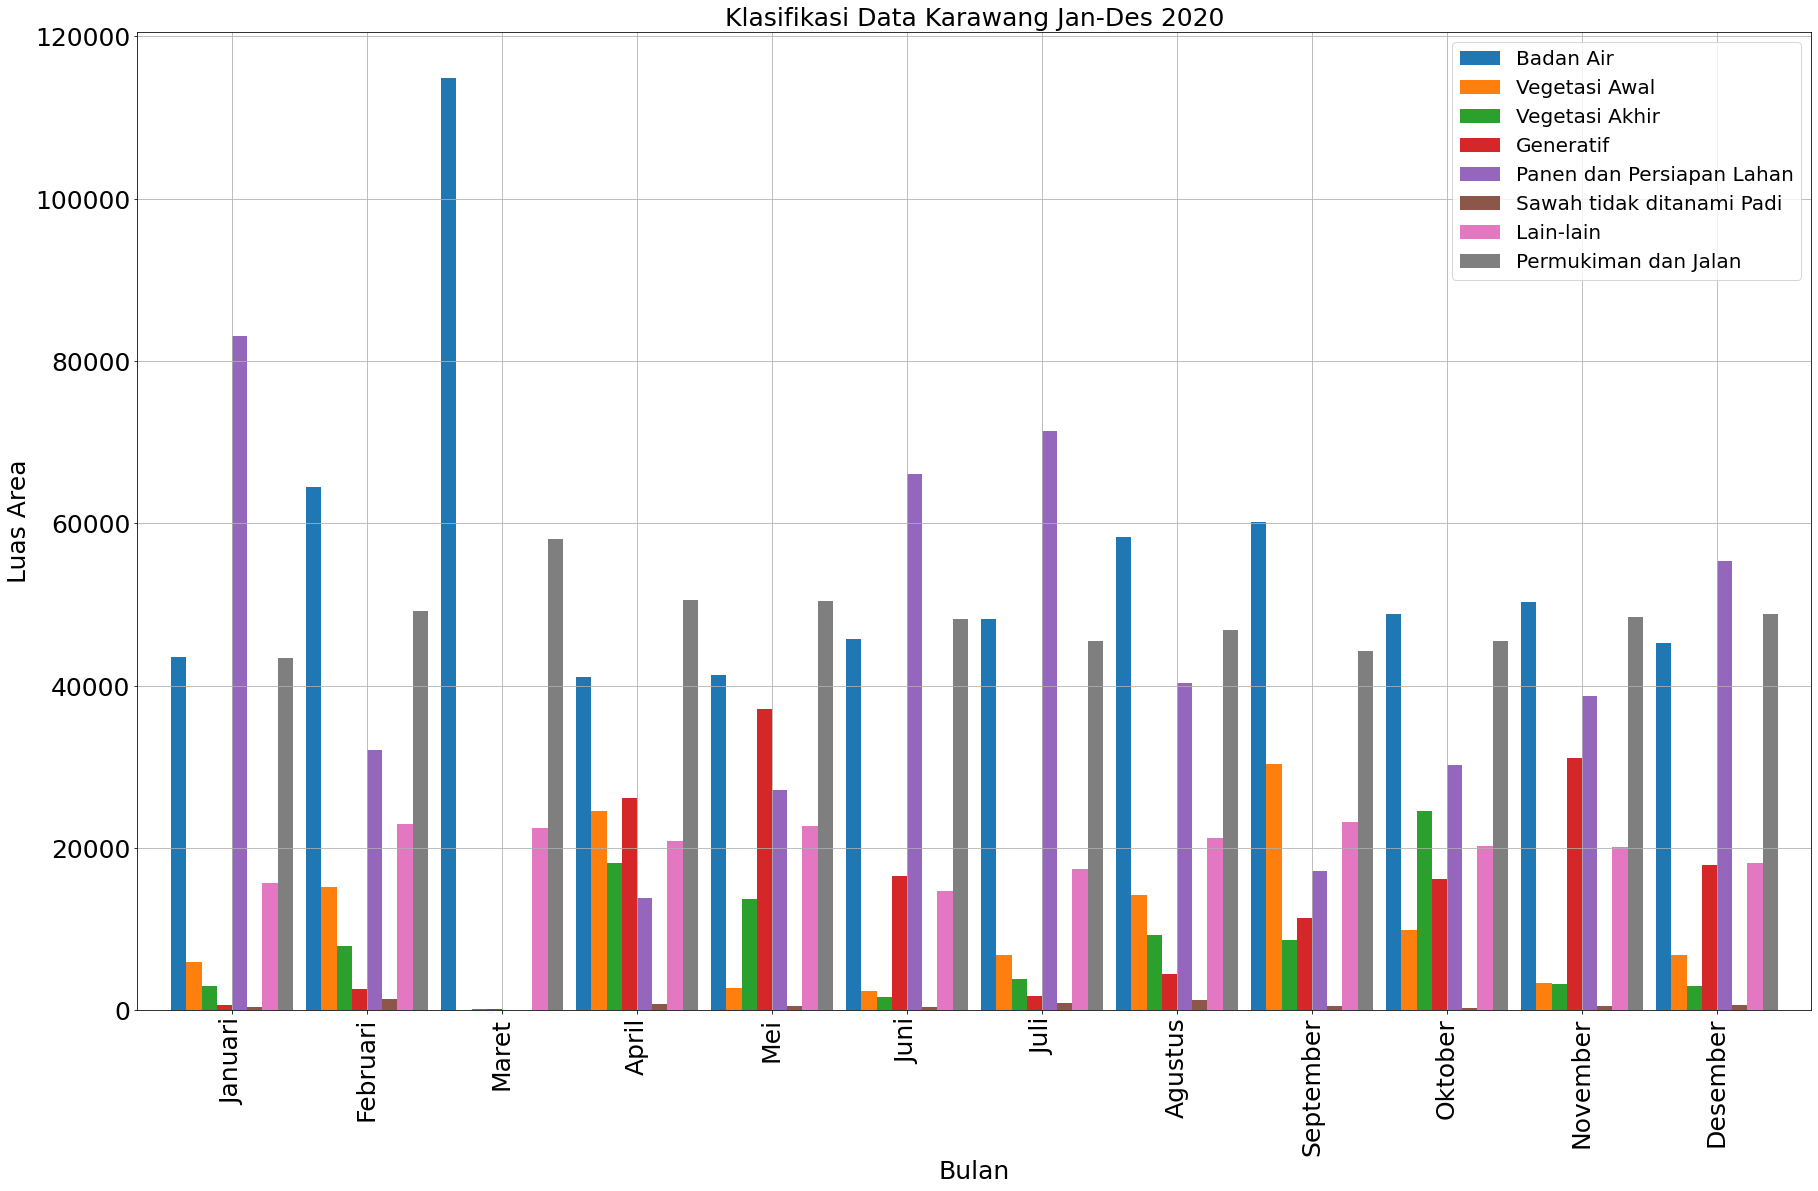

In [37]:
dfgabungan.plot(kind="bar",figsize=(30,18),width=0.9,fontsize=25,legend=True)
plt.title("Klasifikasi Data Karawang Jan-Des 2020", fontsize=25)
plt.xlabel("Bulan", fontsize=25)
plt.ylabel("Luas Area", fontsize =25) #Belum dikali 100
plt.legend(fontsize=20)
plt.grid()

#Perbandingan
# Januari-mei dan september
# februai, juni , oktober
# maret, juli, september dan november

In [38]:
#Membuat dataframe gabungan Jan-Jun
dftotal = pd.DataFrame({'Total': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
dftotal['Bulan'] = ["Januari","Februari", "Maret", "April", "Mei", "Juni","Juli","Agustus","September","Oktober","November","Desember"]
dftotal ['Total'] = [df01.loc[0]['Widearea']+ df01.loc[1]['Widearea']+ df01.loc[2]['Widearea']+ df01.loc[3]['Widearea']+ df01.loc[4]['Widearea']+ df01.loc[5]['Widearea']+ df01.loc[6]['Widearea']+ df01.loc[7]['Widearea'], 
                         df02.loc[0]['Widearea']+ df02.loc[1]['Widearea']+ df02.loc[2]['Widearea']+ df02.loc[3]['Widearea']+ df02.loc[4]['Widearea']+ df02.loc[5]['Widearea']+ df02.loc[6]['Widearea']+ df02.loc[7]['Widearea'],
                         df03.loc[0]['Widearea']+ df03.loc[1]['Widearea']+ df03.loc[2]['Widearea']+ df03.loc[3]['Widearea']+ df03.loc[4]['Widearea']+ df03.loc[5]['Widearea']+ df03.loc[6]['Widearea']+ df03.loc[7]['Widearea'], 
                         df04.loc[0]['Widearea']+ df04.loc[1]['Widearea']+ df04.loc[2]['Widearea']+ df04.loc[3]['Widearea']+ df04.loc[4]['Widearea']+ df04.loc[5]['Widearea']+ df04.loc[6]['Widearea']+ df04.loc[7]['Widearea'], 
                         df05.loc[0]['Widearea']+ df05.loc[1]['Widearea']+ df05.loc[2]['Widearea']+ df05.loc[3]['Widearea']+ df05.loc[4]['Widearea']+ df05.loc[5]['Widearea']+ df05.loc[6]['Widearea']+ df05.loc[7]['Widearea'], 
                         df06.loc[0]['Widearea']+ df06.loc[1]['Widearea']+ df06.loc[2]['Widearea']+ df06.loc[3]['Widearea']+ df06.loc[4]['Widearea']+ df06.loc[5]['Widearea']+ df06.loc[6]['Widearea']+ df06.loc[7]['Widearea'],  
                         df07.loc[0]['Widearea']+ df07.loc[1]['Widearea']+ df07.loc[2]['Widearea']+ df07.loc[3]['Widearea']+ df07.loc[4]['Widearea']+ df07.loc[5]['Widearea']+ df07.loc[6]['Widearea']+ df07.loc[7]['Widearea'],  
                         df08.loc[0]['Widearea']+ df08.loc[1]['Widearea']+ df08.loc[2]['Widearea']+ df08.loc[3]['Widearea']+ df08.loc[4]['Widearea']+ df08.loc[5]['Widearea']+ df08.loc[6]['Widearea']+ df08.loc[7]['Widearea'], 
                         df09.loc[0]['Widearea']+ df09.loc[1]['Widearea']+ df09.loc[2]['Widearea']+ df09.loc[3]['Widearea']+ df09.loc[4]['Widearea']+ df09.loc[5]['Widearea']+ df09.loc[6]['Widearea']+ df09.loc[7]['Widearea'], 
                         df10.loc[0]['Widearea']+ df10.loc[1]['Widearea']+ df10.loc[2]['Widearea']+ df10.loc[3]['Widearea']+ df10.loc[4]['Widearea']+ df10.loc[5]['Widearea']+ df10.loc[6]['Widearea']+ df10.loc[7]['Widearea'], 
                         df11.loc[0]['Widearea']+ df11.loc[1]['Widearea']+ df11.loc[2]['Widearea']+ df11.loc[3]['Widearea']+ df11.loc[4]['Widearea']+ df11.loc[5]['Widearea']+ df11.loc[6]['Widearea']+ df11.loc[7]['Widearea'], 
                         df12.loc[0]['Widearea']+ df12.loc[1]['Widearea']+ df12.loc[2]['Widearea']+ df12.loc[3]['Widearea']+ df12.loc[4]['Widearea']+ df12.loc[5]['Widearea']+ df12.loc[6]['Widearea']+ df12.loc[7]['Widearea']] 
dftotal = dftotal.set_index('Bulan')
dftotal

,Total
Bulan,
Januari,195683
Februari,195683
Maret,195683
April,195683
Mei,195683
Juni,195683
Juli,195683
Agustus,195683
September,195683


## Hitung Rasio Perbedaan

In [39]:
# Hitung rasio untuk cek dominasi
def h(bulan,loc):
    #Data count vegetasi awal maret 2020
    if (bulan == 'Januari'):
        df = df01
    if (bulan =='Februari'):
        df = df02
    if (bulan =='Maret'):
        df = df03
    if (bulan =='April'):
        df = df04
    if (bulan =='Mei'):
        df = df05
    if (bulan =='Juni'):
        df = df06
    if (bulan =='Juli'):
        df = df07
    if (bulan =='Agustus'):
        df = df08
    if (bulan =='September'):
        df = df09
    if (bulan =='Oktober'):
        df = df10
    if (bulan =='November'):
        df = df11
    if (bulan =='Desember'):
        df = df12   
    a = df.loc[loc]['Count']
    #Data count total (tanpa badan air dan pemukiman) maret 2020
    counttotal = df.loc[1]['Count'] + df.loc[2]['Count'] + df.loc[3]['Count'] + df.loc[4]['Count'] + df.loc[5]['Count'] + df.loc[6]['Count']
    # Menghitung persentase
    persentase = a/counttotal*100
    return str(np.around(persentase, 2))+'%'
# h('Januari',3)

In [40]:
#Membuat dataframe gabungan Jan-Jun
dfgabungan1 = pd.DataFrame({'Bulan': pd.Series(dtype='str'),
                   'Vegetasi Awal': pd.Series(dtype='int'),
                   'Vegetasi Akhir': pd.Series(dtype='int'),
                   'Generatif': pd.Series(dtype='int'),
                   'Panen dan Persiapan Lahan': pd.Series(dtype='int'),
                   'Sawah tidak ditanami Padi': pd.Series(dtype='int'),
                   'Lain-lain': pd.Series(dtype='int'),
                   'Permukiman dan Jalan': pd.Series(dtype='int'),})
#Deklarasi nilai awal dalam dataframe
dfgabungan1['Bulan'] = ["Januari","Februari", "Maret", "April", "Mei", "Juni","Juli","Agustus","September","Oktober","November","Desember"]

dfgabungan1 ['Vegetasi Awal'] = [h('Januari',1), 
                            h('Februari',1),
                            h('Maret',1),
                            h('April',1),
                            h('Mei',1),
                            h('Juni',1),
                            h('Juli',1),
                            h('Agustus',1),
                            h('September',1),
                            h('Oktober',1),
                            h('November',1),
                            h('Desember',1)]
dfgabungan1 ['Vegetasi Akhir'] = [h('Januari',2), 
                            h('Februari',2),
                            h('Maret',2),
                            h('April',2),
                            h('Mei',2),
                            h('Juni',2),
                            h('Juli',2),
                            h('Agustus',2),
                            h('September',2),
                            h('Oktober',2),
                            h('November',2),
                            h('Desember',2)]
dfgabungan1 ['Generatif'] = [h('Januari',3), 
                            h('Februari',3),
                            h('Maret',3),
                            h('April',3),
                            h('Mei',3),
                            h('Juni',3),
                            h('Juli',3),
                            h('Agustus',3),
                            h('September',3),
                            h('Oktober',3),
                            h('November',3),
                            h('Desember',3)]
dfgabungan1 ['Panen dan Persiapan Lahan'] =[h('Januari',4), 
                            h('Februari',4),
                            h('Maret',4),
                            h('April',4),
                            h('Mei',4),
                            h('Juni',4),
                            h('Juli',4),
                            h('Agustus',4),
                            h('September',4),
                            h('Oktober',4),
                            h('November',4),
                            h('Desember',4)]
dfgabungan1 ['Sawah tidak ditanami Padi'] = [h('Januari',5), 
                            h('Februari',5),
                            h('Maret',5),
                            h('April',5),
                            h('Mei',5),
                            h('Juni',5),
                            h('Juli',5),
                            h('Agustus',5),
                            h('September',5),
                            h('Oktober',5),
                            h('November',5),
                            h('Desember',5)]
dfgabungan1 ['Lain-lain'] = [h('Januari',6), 
                            h('Februari',6),
                            h('Maret',6),
                            h('April',6),
                            h('Mei',6),
                            h('Juni',6),
                            h('Juli',6),
                            h('Agustus',6),
                            h('September',6),
                            h('Oktober',6),
                            h('November',6),
                            h('Desember',6)]
dfgabungan1 ['Permukiman dan Jalan'] = [h('Januari',7), 
                            h('Februari',7),
                            h('Maret',7),
                            h('April',7),
                            h('Mei',7),
                            h('Juni',7),
                            h('Juli',7),
                            h('Agustus',7),
                            h('September',7),
                            h('Oktober',7),
                            h('November',7),
                            h('Desember',7)]

dfgabungan1 = dfgabungan1.set_index('Bulan')
dfgabungan1

#dibandingkan, diliat yg mayoritas itu diatas 50%, dibandingkan dengan data 1 bulan selain pemukiman, badan air

,Vegetasi Awal,Vegetasi Akhir,Generatif,Panen dan Persiapan Lahan,Sawah tidak ditanami Padi,Lain-lain,Permukiman dan Jalan
Bulan,,,,,,,
Januari,5.51%,2.79%,0.61%,76.34%,0.33%,14.43%,39.91%
Februari,18.47%,9.6%,3.16%,39.1%,1.75%,27.93%,59.95%
Maret,0.0%,0.67%,0.88%,0.0%,0.0%,98.46%,254.55%
April,23.53%,17.36%,25.16%,13.23%,0.72%,20.0%,48.54%
Mei,2.68%,13.22%,35.72%,26.05%,0.45%,21.87%,48.43%
Juni,2.37%,1.54%,16.25%,64.99%,0.39%,14.46%,47.44%
Juli,6.64%,3.75%,1.73%,69.93%,0.89%,17.06%,44.54%
Agustus,15.68%,10.21%,4.92%,44.45%,1.34%,23.4%,51.78%
September,33.28%,9.47%,12.49%,18.79%,0.6%,25.37%,48.44%


In [41]:
# cek rasio bukan sebagai str
def n(bulan,loc):
    #Data count vegetasi awal maret 2020
    if (bulan == 'Januari'):
        df = df01
    if (bulan =='Februari'):
        df = df02
    if (bulan =='Maret'):
        df = df03
    if (bulan =='April'):
        df = df04
    if (bulan =='Mei'):
        df = df05
    if (bulan =='Juni'):
        df = df06
    if (bulan =='Juli'):
        df = df07
    if (bulan =='Agustus'):
        df = df08
    if (bulan =='September'):
        df = df09
    if (bulan =='Oktober'):
        df = df10
    if (bulan =='November'):
        df = df11
    if (bulan =='Desember'):
        df = df12   
    a = df.loc[loc]['Count']
    #Data count total (tanpa badan air dan pemukiman) maret 2020
    counttotal = df.loc[1]['Count'] + df.loc[2]['Count'] + df.loc[3]['Count'] + df.loc[4]['Count'] + df.loc[5]['Count'] + df.loc[6]['Count']
    # Menghitung persentase
    persentase = a/counttotal*100
    return np.around(persentase, 2)

#Membuat dataframe gabungan Jan-Jun
dfgabungan2 = dfgabungan = pd.DataFrame({'Bulan': pd.Series(dtype='str'),
                   'Badan Air': pd.Series(dtype='int'),
                   'Vegetasi Awal': pd.Series(dtype='int'),
                   'Vegetasi Akhir': pd.Series(dtype='int'),
                   'Generatif': pd.Series(dtype='int'),
                   'Panen dan Persiapan Lahan': pd.Series(dtype='int'),
                   'Sawah tidak ditanami Padi': pd.Series(dtype='int'),
                   'Lain-lain': pd.Series(dtype='int'),
                   'Permukiman dan Jalan': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
dfgabungan2['Bulan'] = ["Januari","Februari", "Maret", "April", "Mei", "Juni","Juli","Agustus","September","Oktober","November","Desember"]

dfgabungan2 ['Vegetasi Awal'] = [n('Januari',1), 
                            n('Februari',1),
                            n('Maret',1),
                            n('April',1),
                            n('Mei',1),
                            n('Juni',1),
                            n('Juli',1),
                            n('Agustus',1),
                            n('September',1),
                            n('Oktober',1),
                            n('November',1),
                            n('Desember',1)]
dfgabungan2 ['Vegetasi Akhir'] = [n('Januari',2), 
                            n('Februari',2),
                            n('Maret',2),
                            n('April',2),
                            n('Mei',2),
                            n('Juni',2),
                            n('Juli',2),
                            n('Agustus',2),
                            n('September',2),
                            n('Oktober',2),
                            n('November',2),
                            n('Desember',2)]
dfgabungan2 ['Generatif'] = [n('Januari',3), 
                            n('Februari',3),
                            n('Maret',3),
                            n('April',3),
                            n('Mei',3),
                            n('Juni',3),
                            n('Juli',3),
                            n('Agustus',3),
                            n('September',3),
                            n('Oktober',3),
                            n('November',3),
                            n('Desember',3)]
dfgabungan2 ['Panen dan Persiapan Lahan'] =[n('Januari',4), 
                            n('Februari',4),
                            n('Maret',4),
                            n('April',4),
                            n('Mei',4),
                            n('Juni',4),
                            n('Juli',4),
                            n('Agustus',4),
                            n('September',4),
                            n('Oktober',4),
                            n('November',4),
                            n('Desember',4)]
dfgabungan2 ['Sawah tidak ditanami Padi'] = [n('Januari',5), 
                            n('Februari',5),
                            n('Maret',5),
                            n('April',5),
                            n('Mei',5),
                            n('Juni',5),
                            n('Juli',5),
                            n('Agustus',5),
                            n('September',5),
                            n('Oktober',5),
                            n('November',5),
                            n('Desember',5)]
dfgabungan2 ['Lain-lain'] = [n('Januari',6), 
                            n('Februari',6),
                            n('Maret',6),
                            n('April',6),
                            n('Mei',6),
                            n('Juni',6),
                            n('Juli',6),
                            n('Agustus',6),
                            n('September',6),
                            n('Oktober',6),
                            n('November',6),
                            n('Desember',6)]
dfgabungan2 ['Permukiman dan Jalan'] = [n('Januari',7), 
                            n('Februari',7),
                            n('Maret',7),
                            n('April',7),
                            n('Mei',7),
                            n('Juni',7),
                            n('Juli',7),
                            n('Agustus',7),
                            n('September',7),
                            n('Oktober',7),
                            n('November',7),
                            n('Desember',7)]

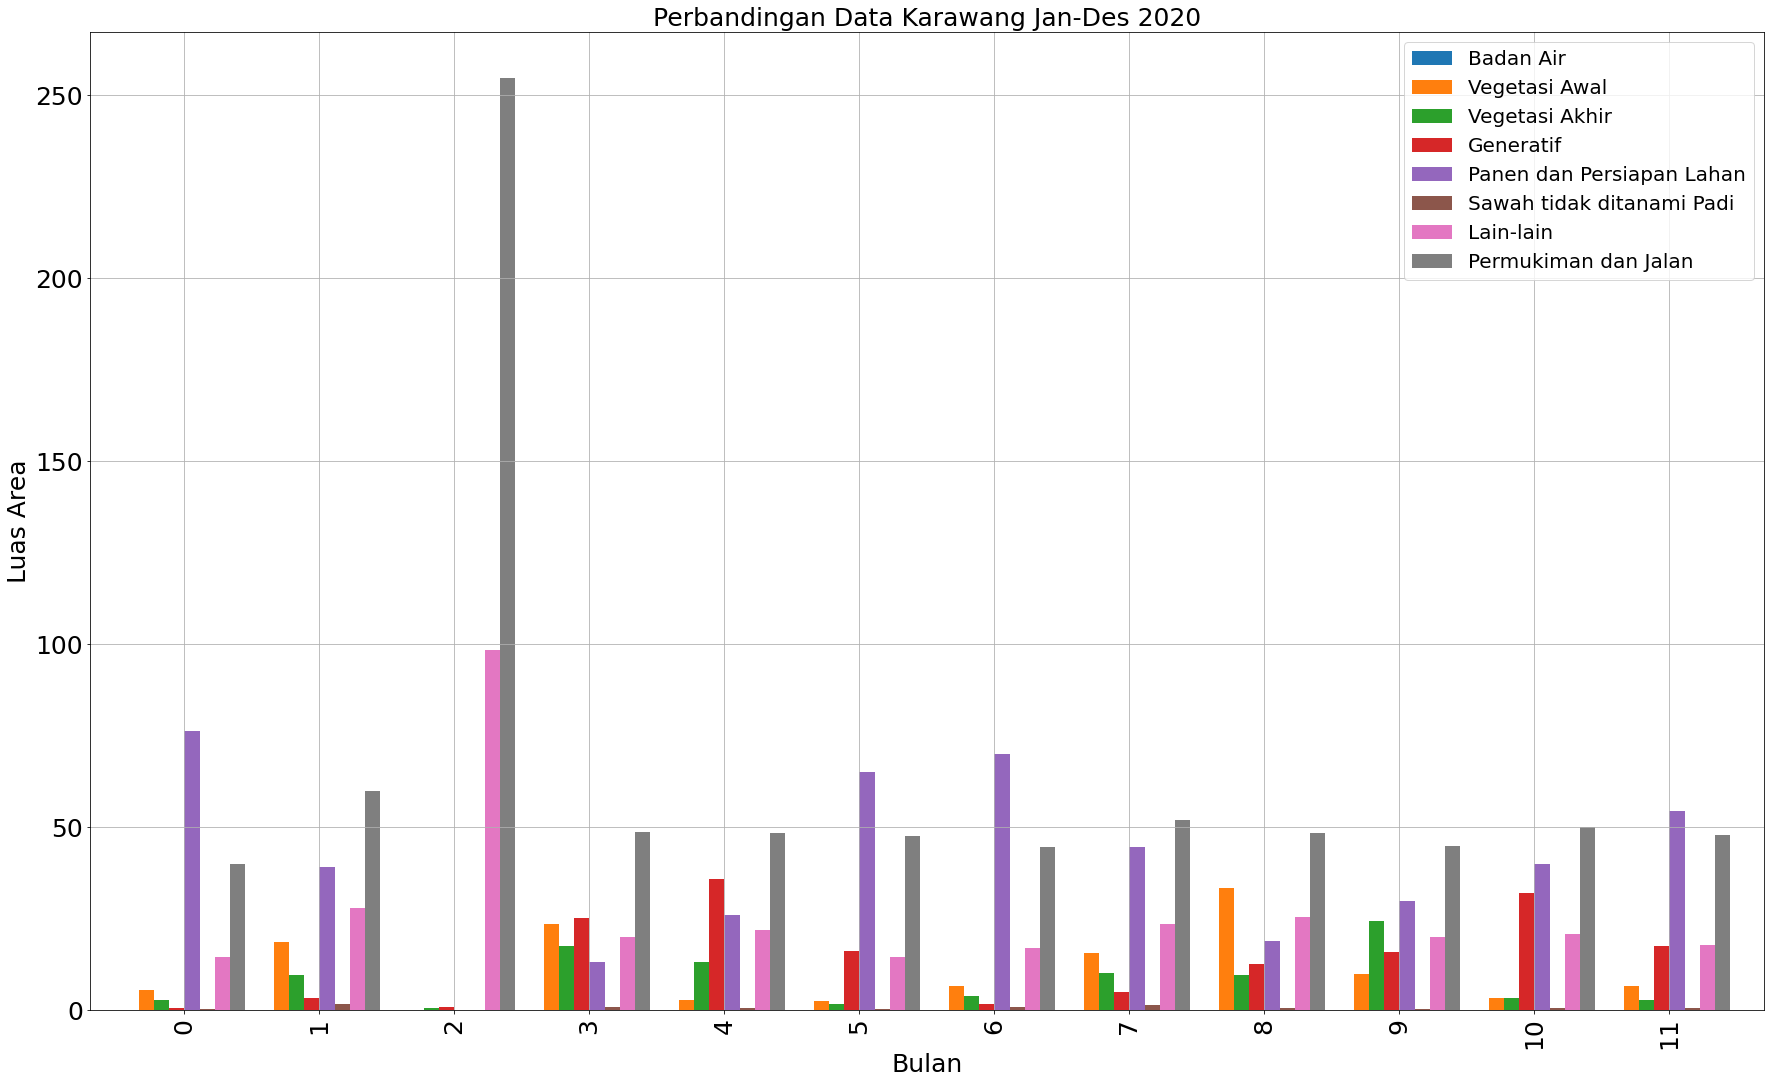

In [42]:
import matplotlib.pyplot as plt
dfgabungan2.plot(kind="bar",figsize=(30,18),width=0.9,fontsize=25,legend=True)
plt.title("Perbandingan Data Karawang Jan-Des 2020", fontsize=25)
plt.xlabel("Bulan", fontsize=25)
plt.ylabel("Luas Area", fontsize =25) #Belum dikali 100
plt.legend(fontsize=20)
plt.grid()

#Perbandingan
# Januari-mei dan september
# februai, juni , oktober
# maret, juli, september dan november

# Grafik Perbandingan

In [43]:
# !pip install openpyxl

In [44]:
ksa = pd.read_excel('hasil_ksa_2020.xlsx')
# print(dataframe1)

In [45]:
def showPlotBanding(n, label):
    x_ar = [ksa[n][1], ksa[n][2], ksa[n][4],ksa[n][5],ksa[n][6],ksa[n][7],ksa[n][8],ksa[n][9],ksa[n][10],ksa[n][11],ksa[n][12]]
    y_ar = [df01.loc[n]['Widearea'], 
               df02.loc[n]['Widearea'], 
               df04.loc[n]['Widearea'], 
               df05.loc[n]['Widearea'], 
               df06.loc[n]['Widearea'],
               df07.loc[n]['Widearea'], 
               df08.loc[n]['Widearea'], 
               df09.loc[n]['Widearea'], 
               df10.loc[n]['Widearea'], 
               df11.loc[n]['Widearea'], 
               df12.loc[n]['Widearea']]
    x_arr = np.array(x_ar)
    y_arr = np.array(y_ar)
    forPlot = pd.DataFrame({
       str(label)+' KSA': x_arr,
       str(label)+' RF': y_arr}, index=["Januari","Februari", "April", "Mei", "Juni","Juli","Agustus","September","Oktober","November","Desember"])

    lines = forPlot.plot.line()
#     index=["Januari","Februari", "April", "Mei", "Juni","Juli","Agustus","September","Oktober","November","Desember"]
#     for x,y in zip(index,y_arr):

#         label1 = "{:.2f}".format(y)

#         plt.annotate(label1, # this is the text
#                      (x,y), # this is the point to label
#                      textcoords="offset points", # how to position the text
#                      xytext=(0,10), # distance from text to points (x,y)
#                      ha='center') # horizontal alignment can be
#     for x,y in zip(index,x_arr):    
#         labelk = "{:.2f}".format(x)
#         plt.annotate(labelk, # this is the text
#                      (x,x), # this is the point to label
#                      textcoords="offset points", # how to position the text
#                      xytext=(0,10), # distance from text to points (x,y)
#                      ha='center') # horizontal alignment can be
    return lines

<AxesSubplot:>

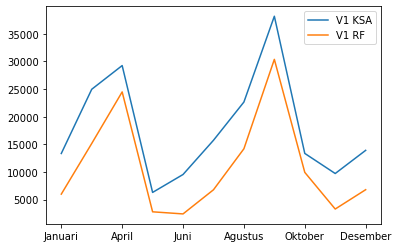

In [46]:
# Vegetasi Awal
showPlotBanding(1,'V1')

<AxesSubplot:>

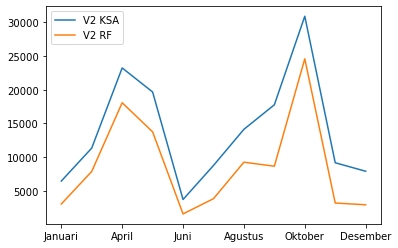

In [47]:
# Vegetasi Akhir
showPlotBanding(2,'V2')

<AxesSubplot:>

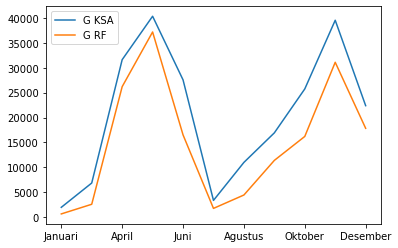

In [48]:
# Generatif
showPlotBanding(3,'G')

<AxesSubplot:>

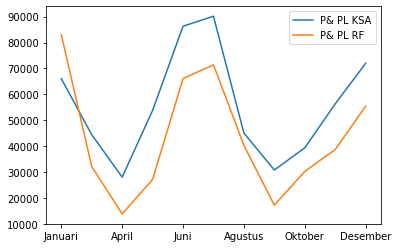

In [49]:
# P&PL
showPlotBanding(4,'P& PL')

<AxesSubplot:>

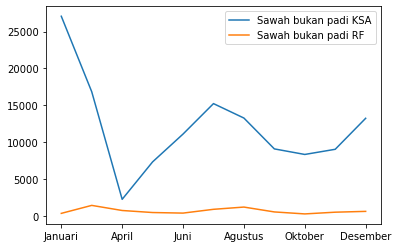

In [50]:
# Sawah bukan padi
# ga masuk paper kayaknya
showPlotBanding(5,'Sawah bukan padi')